## Random forest classifier
---
#### Elo notes

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

## ROC Curve
### Confusion matrix

---
In the field of machine learning and specifically the problem of statistical classification, a confusion matrix, also known as an error matrix.

Receiver operating characteristic (ROC), or ROC curve, is a graphical plot that illustrates the performance of a binary classifier system as its discrimination threshold is varied. The curve is created by plotting the true positive rate (TPR/sensitivity/recall/probability of detection in machine learning) against the false positive rate (FPR/"1 - specificity") at various threshold settings. 

"1 - specificity" when specificity is reported as a value from 0 to 1.0, and other times (as in the image above) we'll use "100 - specificity" when it is reported as a percentage from 0 to 100.


The diagonal ROC line for an uninformative test:

(sensitivity + specificity = 1)

The trade-offs that we make when we insist on higher sensitivity. The result is lower specificity, and more false positives.

You can also see that a perfect test would begin in the lower left corner, go straight up to the upper left corner, and then to the upper right corner (that is, it would be 100% sensitive and 100% specific). The area underneath this curve would be the entire square, or 1.0. On the other hand, a diagonal line from lower left to upper right traces the curve for a perfectly useless test - one that is no better than tossing a coin. The area under this curve is 0.5. So, a useless test has an area under the ROC curve (AUROCC) of 0.5, and a perfect test has an AUROCC of 1.0.

Remember, though, that the sensitivity and specificity depend on where we make the cutpoint(threshold)

Note: we say "1-specificity" but in reality it is also "100% - specificity"

The area under the ROC curve (AUROCC) is a reflection of how good the test is at distinguishing (or "discriminating").

If you have two tests, you can compare the AUROCC of the tests to determine which is better overall.

**Error Metrics for Skewed Classes**

It is sometimes difficult to tell whether a reduction in error is actually an improvement of the algorithm.

For example: In predicting a cancer diagnoses where 0.5% of the examples have cancer, we find our learning algorithm has a 1% error. However, if we were to simply classify every single example as a 0, then our error would reduce to 0.5% even though we did not improve the algorithm.

This usually happens with skewed classes; that is, when our class is very rare in the entire data set.

Or to say it another way, when we have lot more examples from one class than from the other class.

For this we can use Precision/Recall.

Predicted: 1, Actual: 1 --- True positive

Predicted: 0, Actual: 0 --- True negative

Predicted: 0, Actual, 1 --- False negative

Predicted: 1, Actual: 0 --- False positive

**Precision:** of all patients we predicted where y=1, what fraction actually has cancer? - How many selected items are relevant?

True Positives/Total number of predicted positives = True Positives/[True Positives+False positives]

**Sensitivity / Recall:** Of all the patients that actually have cancer, what fraction did we correctly detect as having cancer? - How many relevant items are selected?

True Positives/Total number of actual positives = True Positives/[True Positives+False negatives]

These two metrics give us a better sense of how our classifier is doing. We want both precision and recall to be high.



In the example at the beginning of the section, if we classify all patients as 0, then our recall will be $0/(0+f)=0$, so despite having a lower error percentage, we can quickly see it has worse recall.

Note 1: if an algorithm predicts only negatives like it does in one of exercises, the precision is not defined, it is impossible to divide by 0. F1 score will not be defined too.



**Trading Off Precision and Recall**

We might want a confident prediction of two classes using logistic regression. One way is to increase our threshold:

Predict 1 if: $hθ(x)≥0.7$

Predict 0 if: $hθ(x)<0.7$

This way, we only predict cancer if the patient has a 70% chance.

Doing this, we will have higher precision but lower recall (refer to the definitions in the previous section).

In the opposite example, we can lower our threshold:

Predict 1 if: $hθ(x)≥0.3$

Predict 0 if: $hθ(x)<0.3$

That way, we get a very safe prediction. This will cause higher recall but lower precision.

The greater the threshold, the greater the precision and the lower the recall.

The lower the threshold, the greater the recall and the lower the precision.


In order to turn these two metrics into one single number, we can take the F value.

One way is to take the average:

$(P+R) / 2$ ATTENTION: NOT TO USE

This does not work well. If we predict all y=0 then that will bring the average up despite having 0 recall. If we predict all examples as y=1, then the very high recall will bring up the average despite having 0 precision.

A better way is to compute the F Score (or F1 score):

**F-measure**

A measure that combines precision and recall is the harmonic mean of precision and recall, the traditional F-measure or balanced F-score

$ {\displaystyle F=2\cdot {\frac {\mathrm {precision} \cdot \mathrm {recall} }{\mathrm {precision} +\mathrm {recall} }}}$


$F Score = 2*\frac{P*R}{P+R}$

In order for the F Score to be large, both precision and recall must be large.

We want to train precision and recall on the cross validation set so as not to bias our test set.

**Precision and recall**

In pattern recognition and information retrieval with binary classification, precision (also called positive predictive value) is the fraction of retrieved instances that are relevant, while recall (also known as sensitivity) is the fraction of relevant instances that are retrieved. Both precision and recall are therefore based on an understanding and measure of relevance.

---


  * The true-positive rate is also known as sensitivity, or recall in machine learning.
  * The false-positive rate is also known as the fall-out and can be calculated as (1 - specificity)

**True positive rate**

```
 number of true positives     number correctly predicted positive
-------------------------- = -------------------------------------
 number of positive cases           number of positive cases
```

**False positive rate**

```
 number of false positives     number incorrectly predicted positive
--------------------------- = ---------------------------------------
  number of negative cases           number of negative cases
```
---
**Sensitivity / Recall / TPR**

The recall is the ratio $tp / (tp + fn)$ where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

*The best value is 1 and the worst value is 0.*

The precision_recall_curve computes a precision-recall curve from the ground truth label and a score given by the classifier by varying a decision threshold.

The average_precision_score function computes the average precision (AP) from prediction scores. This score corresponds to the area under the precision-recall curve. The value is between 0 and 1 and higher is better. With random predictions, the AP is the fraction of positive samples.



---
**Standardize features**

by removing the mean and scaling to unit variance

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using the transform method.

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

This scaler can also be applied to sparse CSR or CSC matrices by passing with_mean=False to avoid breaking the sparsity structure of the data.

---
**KFold** 

Divides all the samples in k groups of samples, called folds (if k = n, this is equivalent to the Leave One Out strategy), of equal sizes (if possible). The prediction function is learned using k - 1 folds, and the fold left out is used for test.



In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB


from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

from scipy.stats import itemfreq
from scipy import interp

from prettytable import PrettyTable
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

plt.style.use('seaborn-deep')
matplotlib.style.use('ggplot')

%matplotlib inline

DeprecationWaring:

http://scikit-learn.org/stable/whats_new.html

In [7]:
df = pd.read_csv('data/churn.csv')

In [8]:
df[:2]

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False.


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
State             3333 non-null object
Account Length    3333 non-null int64
Area Code         3333 non-null int64
Phone             3333 non-null object
Int'l Plan        3333 non-null object
VMail Plan        3333 non-null object
VMail Message     3333 non-null int64
Day Mins          3333 non-null float64
Day Calls         3333 non-null int64
Day Charge        3333 non-null float64
Eve Mins          3333 non-null float64
Eve Calls         3333 non-null int64
Eve Charge        3333 non-null float64
Night Mins        3333 non-null float64
Night Calls       3333 non-null int64
Night Charge      3333 non-null float64
Intl Mins         3333 non-null float64
Intl Calls        3333 non-null int64
Intl Charge       3333 non-null float64
CustServ Calls    3333 non-null int64
Churn?            3333 non-null object
dtypes: float64(8), int64(8), object(5)
memory usage: 546.9+ KB


In [10]:
pd.set_option('display.max_columns', None)

In [11]:
df[:2]

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False.


In [12]:
df["Int'l Plan"].unique()

array(['no', 'yes'], dtype=object)

In [13]:
# object to boolean
df["Int'l Plan"] = df["Int'l Plan"] == 'yes'

In [14]:
df['VMail Plan'].unique()

array(['yes', 'no'], dtype=object)

In [15]:
df['VMail Plan'] = df['VMail Plan'] == 'yes'

In [16]:
df['Churn?'].unique()

array(['False.', 'True.'], dtype=object)

In [17]:
df['Churn?'] = df['Churn?'] == 'True.'

In [18]:
df[:2]

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False
1,OH,107,415,371-7191,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False


In [19]:
df = df.drop(['State', 'Area Code', 'Phone'], axis=1)

In [20]:
df[:2]

,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,128,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False
1,107,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False


In [21]:
y = df.pop('Churn?').values

In [22]:
feature_names = df.columns
feature_names

Index([u'Account Length', u'Int'l Plan', u'VMail Plan', u'VMail Message',
       u'Day Mins', u'Day Calls', u'Day Charge', u'Eve Mins', u'Eve Calls',
       u'Eve Charge', u'Night Mins', u'Night Calls', u'Night Charge',
       u'Intl Mins', u'Intl Calls', u'Intl Charge', u'CustServ Calls'],
      dtype='object')

In [23]:
X = df.values

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [25]:
modelrf = RandomForestClassifier()
modelrf.fit(X_train, y_train)
yhat = modelrf.predict(X_test)

In [26]:
acc = np.sum(yhat == y_test)/float(len(y_test)) 
acc

0.94124700239808157

In [27]:
modelrf.score(X_test, y_test)

0.94124700239808157

In [28]:
cmatrix = confusion_matrix(y_test, yhat)
cmatrix

array([[716,   2],
       [ 47,  69]])

In [29]:
pd.DataFrame(cmatrix, columns = ['[Prediction] H0: Fail to reject H0 | 0 ', '[Prediction] H0: Rejected H0 (Ha accepted) | 1'], index=['H0: True | 0', 'H0: False | 1 '])

,[Prediction] H0: Fail to reject H0 | 0,[Prediction] H0: Rejected H0 (Ha accepted) | 1
H0: True | 0,716,2
H0: False | 1,47,69


In [30]:
TN = cmatrix[0][0]
FP = cmatrix[0][1]
FN = cmatrix[1][0]
TP = cmatrix[1][1]

In [31]:
print TN, FP
print FN, TP

716 2
47 69


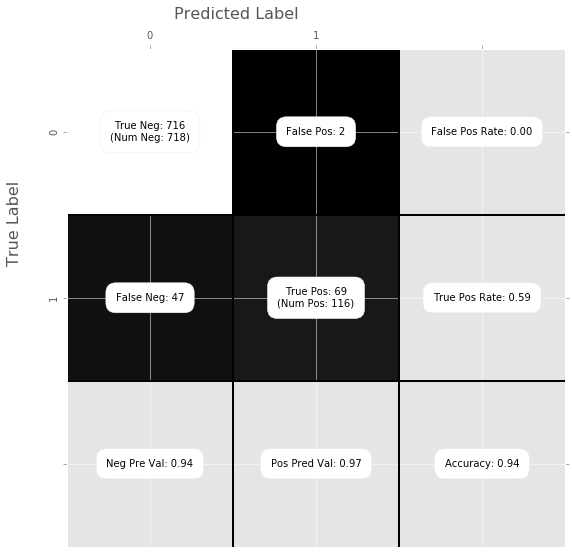

In [34]:
tn, fn, fp, tp, NN, NP, FPR, TPR, NPV, PPV, Acc = show_confusion_matrix_(cmatrix,class_labels=['0','1'])

In [33]:
def show_confusion_matrix_(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    FPR = fp / (fp+tn+0.)
    TPR = tp / (tp+fn+0.)
    NPV = 1-fn/(fn+tn+0.)
    PPV = tp/(tp+fp+0.)
    Acc = (tp+tn+0.)/N
    
    plt.tight_layout()
    plt.show()
    
    return tn, fn, fp, tp, NN, NP, round(FPR,2), round(TPR, 2), round(NPV, 2), round(PPV, 2), round(Acc, 2)


In [35]:
print tn, fn, fp, tp, NN, NP, FPR, TPR, NPV, PPV, Acc

716 47 2 69 718 116 0.0 0.59 0.94 0.97 0.94


In [36]:
precision = precision_score(y_test, yhat)
recall = recall_score(y_test, yhat)

In [37]:
print 'Precision: {:1.4f}'.format(precision)

Precision: 0.9718


In [38]:
print 'Recall: {:1.4f}'.format(recall)

Recall: 0.5948


In [39]:
model1 = RandomForestClassifier(n_estimators= 20, oob_score = True)
model1.fit(X_train, y_train)
yhat1 = model1.predict(X_test)

In [40]:
ooscore = model1.oob_score_
m1_acc = model1.score(X_test, y_test) 

In [41]:
print 'OOB score: {:1.4f}'.format(ooscore)
print 'Accuracy: {:1.4f}'.format(m1_acc)

OOB score: 0.9432
Accuracy: 0.9365


---
### Feature importance

In [42]:
def acc_tree_plot(X_train, y_train, X_test, y_test, initree, stoptree, freq):
    acc = []
    trees = range(initree,stoptree, freq)
    
    for tree in trees:
        model = RandomForestClassifier(n_estimators=tree)
        model.fit(X_train, y_train)
        accuracy = model.score(X_test, y_test)
        acc.append(accuracy)
     

    plt.plot(trees, acc, label= 'Test')
    plt.xlabel('Number of trees')
    plt.ylabel('Accuracy')
    plt.legend()
    


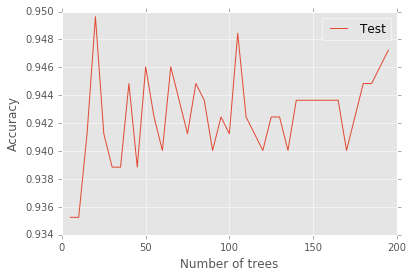

In [43]:
acc_tree_plot(X_train, y_train, X_test, y_test, 5, 200, 5)

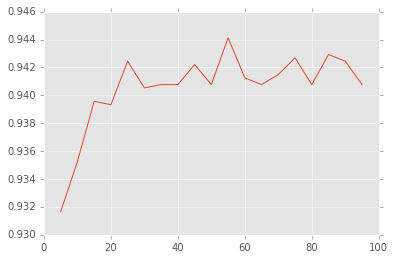

In [85]:
num_trees = range(5, 100, 5)
accuracies = []
for n in num_trees:
    tot = 0
    for i in xrange(5):
        rf = RandomForestClassifier(n_estimators=n)
        rf.fit(X_train, y_train)
        tot += rf.score(X_test, y_test)
    accuracies.append(tot / 5)
plt.plot(num_trees, accuracies)
plt.show()

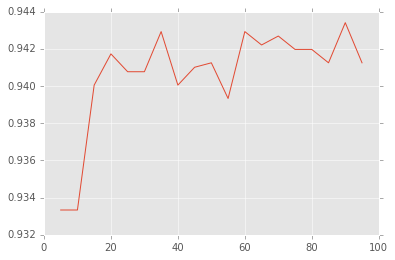

In [87]:
trees = range(5, 100, 5)
forests = xrange(5)
acc = []

for tree in trees:
    total_score = 0
    for forest in forests:
        model = RandomForestClassifier(n_estimators=tree)
        model.fit(X_train, y_train)
        total_score += model.score(X_test, y_test)
    acc.append(total_score / len(forests))

plt.plot(trees, acc)
plt.show()

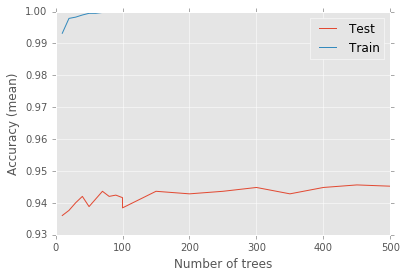

In [44]:
acc = []
acc_train = []
trees = range(10, 110, 10)+range(100, 550, 50)

for tree in trees:
    tree_acc = []
    tree_acc_train = []
    for forest in range(3):
        model = RandomForestClassifier(n_estimators=tree)
        model.fit(X_train, y_train)
        tree_acc.append(model.score(X_test, y_test))
        tree_acc_train.append(model.score(X_train, y_train))
    acc.append(np.mean(tree_acc))
    acc_train.append(np.mean(tree_acc_train))

plt.plot(trees, acc, label='Test')
plt.plot(trees, acc_train, label='Train')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy (mean)')
plt.legend()
plt.show()

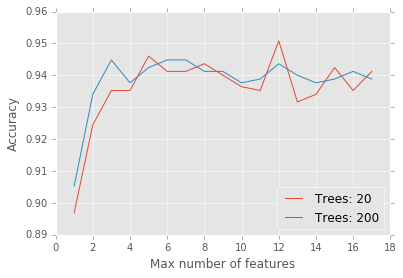

In [45]:
features = len(feature_names)
acc1, acc2 = [], []
for j in xrange(1, features+1, 1):
    rf1 = RandomForestClassifier(n_estimators=20, max_features=j)
    rf2 = RandomForestClassifier(n_estimators=200, max_features=j)
    rf1.fit(X_train, y_train)
    rf2.fit(X_train, y_train)
    acc1.append(rf1.score(X_test, y_test))
    acc2.append(rf2.score(X_test, y_test))

plt.plot(range(1, features+1, 1), acc1, label='Trees: 20')
plt.plot(range(1, features+1, 1), acc2, label='Trees: 200')
plt.xlabel('Max number of features')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

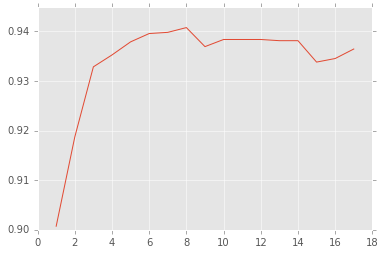

In [90]:
num_features = range(1, len(feature_names) + 1)
accuracies = []
for n in num_features:
    tot = 0
    for i in xrange(5):
        rf = RandomForestClassifier(max_features=n)
        rf.fit(X_train, y_train)
        tot += rf.score(X_test, y_test)
    accuracies.append(tot / 5)
plt.plot(num_features, accuracies)
plt.show()

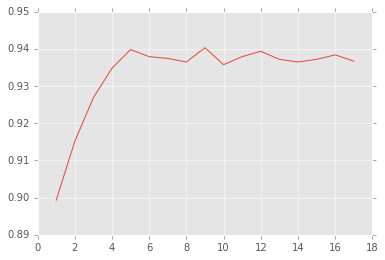

In [91]:
features = range(1, len(feature_names)+1)
fforests = xrange(5)
acc_fea = []

for feature in features:
    total_score_fea = 0
    for forest in fforests:
        model = RandomForestClassifier(max_features=feature)
        model.fit(X_train, y_train)
        total_score_fea += model.score(X_test, y_test)
    acc_fea.append(total_score_fea / len(fforests))

plt.plot(features, acc_fea)
plt.show()



In [46]:
def max_features_optimization(X_train, y_train, X_test, y_test, estm1, estm2, feature_names):
    features = len(feature_names)
    acc1, acc2 = [], []
    for j in xrange(1, features+1, 1):
        rf1 = RandomForestClassifier(n_estimators=estm1, max_features=j)
        rf2 = RandomForestClassifier(n_estimators=estm2, max_features=j)
        rf1.fit(X_train, y_train)
        rf2.fit(X_train, y_train)
        acc1.append(rf1.score(X_test, y_test))
        acc2.append(rf2.score(X_test, y_test))

    plt.plot(range(1, features+1, 1), acc1, label='Trees: 20')
    plt.plot(range(1, features+1, 1), acc2, label='Trees: 200')
    plt.xlabel('Max number of features')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

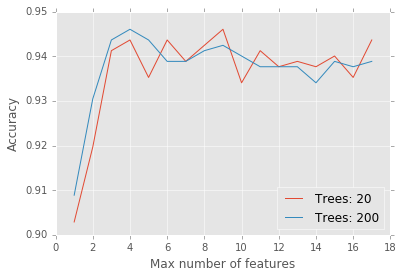

In [47]:
max_features_optimization(X_train, y_train, X_test, y_test, 20, 200, feature_names)

In [92]:
def get_scores(classifier, X_train, X_test, y_train, y_test, **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    return model.score(X_test, y_test), precision_score(y_test, y_hat), recall_score(y_test, y_hat)
    

In [101]:
print 'Model: Accuracy, Precision, Recall'
print ' Random Forest:', get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test, n_estimators=25, max_features=5)
print ' Logistic Regression:', get_scores(LogisticRegression, X_train, X_test, y_train, y_test)
print ' Decision tree:', get_scores(DecisionTreeClassifier, X_train, X_test, y_train, y_test)
print ' SVM:', get_scores(SVC, X_train, X_test, y_train, y_test)
print ' Naive Bayes:', get_scores(MultinomialNB, X_train, X_test, y_train, y_test)

Model: Accuracy, Precision, Recall
 Random Forest: (0.94484412470023982, 0.91666666666666663, 0.66379310344827591)
 Logistic Regression: (0.87170263788968827, 0.63636363636363635, 0.18103448275862069)
 Decision tree: (0.91007194244604317, 0.69523809523809521, 0.62931034482758619)
 SVM: (0.86091127098321341, 0.0, 0.0)
 Naive Bayes: (0.60911270983213428, 0.20000000000000001, 0.60344827586206895)


In [48]:
def testing_model(test_model, X_train, y_train, X_test, y_test, name, *args, **kwargs):
    model = test_model(*args, **kwargs)
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    
    acc = model.score(X_test, y_test)
    preci = precision_score(y_test, yhat)
    recall = recall_score(y_test, yhat)
    
    pretty = PrettyTable(['Metric', 'Score'])
    pretty.add_row(['Accuracy','{:1.4f}'.format(acc)])
    pretty.add_row(['Precision', '{:1.4f}'.format(preci)])
    pretty.add_row(['Recall', '{:1.4f}'.format(recall)])
    print(pretty)
    
    return pd.DataFrame({'Accuracy':acc, 'Precision':preci, 'Recall': recall}, index=[name])

In [49]:
logistic_score = testing_model(LogisticRegression, X_train, y_train, X_test, y_test, 'LogicReg')

+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 0.8717 |
| Precision | 0.6364 |
|   Recall  | 0.1810 |
+-----------+--------+


In [50]:
logistic_score

,Accuracy,Precision,Recall
LogicReg,0.871703,0.636364,0.181034


In [51]:
dt_score = testing_model(DecisionTreeClassifier, X_train, y_train, X_test, y_test, 'Dtree') 

+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 0.9125 |
| Precision | 0.7172 |
|   Recall  | 0.6121 |
+-----------+--------+


In [52]:
dt_score

,Accuracy,Precision,Recall
Dtree,0.91247,0.717172,0.612069


In [53]:
knn_score = testing_model(KNeighborsClassifier, X_train, y_train, X_test, y_test, 'Knn')

+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 0.8825 |
| Precision | 0.7143 |
|   Recall  | 0.2586 |
+-----------+--------+


In [54]:
knn_score

,Accuracy,Precision,Recall
Knn,0.882494,0.714286,0.258621


In [55]:
rf_score = testing_model(RandomForestClassifier, X_train, y_train, X_test, y_test, 'Rforest')

+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 0.9365 |
| Precision | 0.9565 |
|   Recall  | 0.5690 |
+-----------+--------+


In [56]:
rf_score

,Accuracy,Precision,Recall
Rforest,0.936451,0.956522,0.568966


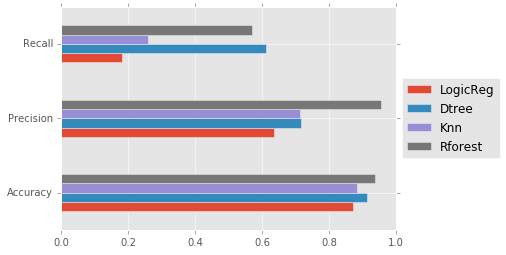

In [57]:
analizing = pd.concat([logistic_score, dt_score, knn_score, rf_score])
analizing.T.plot(kind='barh')
plt.legend(loc='center left', bbox_to_anchor=[1, .5])
plt.show()

In [58]:
def plot_roc_(X, y, clf_class, **kwargs):
    normalization = StandardScaler()
    X = normalization.fit_transform(X)
    kf = KFold(len(y), n_folds=5, shuffle=True)
    yprob = np.zeros((len(y), 2))
    tpr_mean = 0.0
    fpr_mean = np.linspace(0,1,100)
    
    for i, (train_index, test_index) in enumerate(kf):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        model = clf_class(**kwargs)
        model.fit(X_train, y_train)
        
        yprob[test_index] = model.predict_proba(X_test)
        fpr, tpr, threshold = roc_curve(y[test_index], yprob[test_index, 1])
        tpr_mean += interp(fpr_mean, fpr, tpr)
        tpr_mean[0]=0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold {} (area = {:1.2f})'.format(i, roc_auc))
    
    tpr_mean /= len(kf)
    tpr_mean[-1] = 1.0
    auc_mean = auc(fpr_mean, tpr_mean)
    
    plt.plot(fpr_mean, tpr_mean,'k--',label='Mean ROC (area = {:1.2f})'.format(auc_mean), lw=2)
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{}\n\nReceiver operating characteristic'.format(clf_class))
    plt.legend(loc="lower right")
    plt.show()
    
    

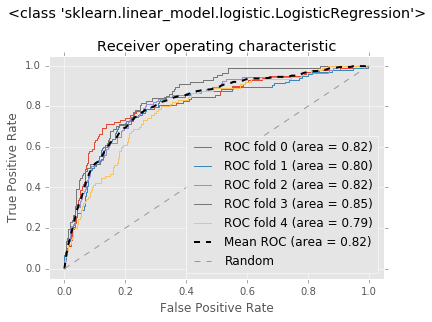

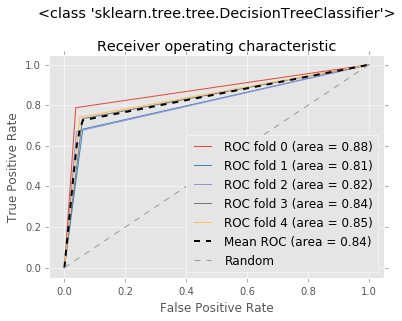

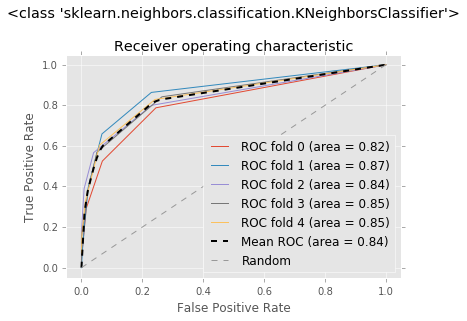

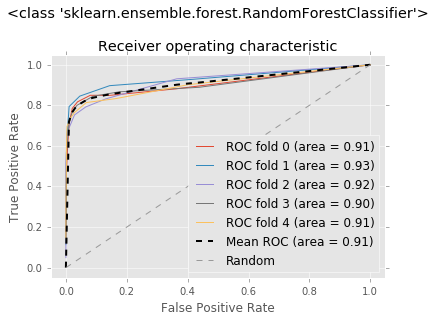

In [59]:
for model in (LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, RandomForestClassifier):
    plot_roc_(X.astype(float), y.astype(float), model)

**Feature importance**

In [78]:
feature_importance = pd.Series(model1.feature_importances_, index=feature_names)
feature_importance = feature_importance.sort_values()
#feature_importance = feature_importance.sort_values(ascending=False)
feature_importance

Night Calls       0.026906
VMail Plan        0.027488
VMail Message     0.027493
Day Calls         0.028083
Eve Calls         0.030152
Night Charge      0.032677
Account Length    0.033893
Intl Charge       0.036490
Night Mins        0.044426
Intl Mins         0.051987
Intl Calls        0.054983
Eve Charge        0.055650
Eve Mins          0.076265
Int'l Plan        0.090014
CustServ Calls    0.116185
Day Mins          0.129791
Day Charge        0.137517
dtype: float64

In [61]:
model1.feature_importances_

array([ 0.03389306,  0.09001363,  0.02748798,  0.02749317,  0.12979129,
        0.02808349,  0.13751735,  0.07626547,  0.03015235,  0.05565025,
        0.04442569,  0.02690601,  0.03267653,  0.05198694,  0.05498252,
        0.03648953,  0.11618475])

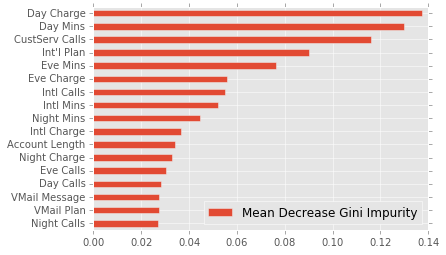

In [62]:
feature_score = pd.DataFrame({'Mean Decrease Gini Impurity': model1.feature_importances_}, index=feature_names)
feature_score = feature_score.sort_values('Mean Decrease Gini Impurity')
feature_score.plot(kind = 'barh');

In [63]:
std_dev = np.std([tree.feature_importances_ for tree in model1.estimators_], axis=0)
features_indexes = np.argsort(feature_importance)
features_indexes

Day Charge        16
Day Mins          15
CustServ Calls    14
Int'l Plan        13
Eve Mins          12
Eve Charge        11
Intl Calls        10
Intl Mins          9
Night Mins         8
Intl Charge        7
Account Length     6
Night Charge       5
Eve Calls          4
Day Calls          3
VMail Message      2
VMail Plan         1
Night Calls        0
dtype: int64

In [64]:
std_dev

array([ 0.01432213,  0.02818037,  0.02416163,  0.01956807,  0.06312591,
        0.01214621,  0.06518293,  0.02594987,  0.01275816,  0.02398128,
        0.01545429,  0.01320675,  0.009379  ,  0.02619644,  0.02273847,
        0.01806103,  0.02468884])

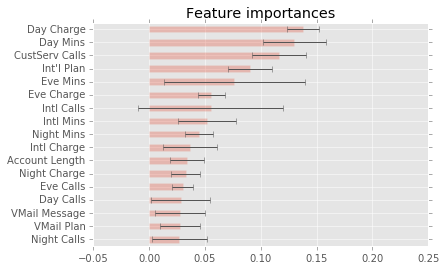

In [79]:
plt.figure()
feature_importance.plot(kind='barh', xerr= std_dev[features_indexes], alpha=0.3)
plt.title('Feature importances')
plt.xlim(-.05, .25)
plt.show()

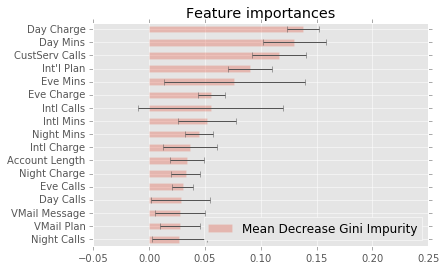

In [74]:
# error bars chart, where the width of the bars is the equal to the standard deviation for that feature.
feature_score.plot(kind='barh', xerr= std_dev[features_indexes], alpha=0.3)
plt.title('Feature importances')
plt.xlim(-.05, .25)
plt.show()

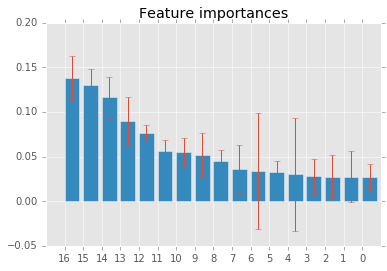

In [70]:
plt.figure()
plt.title('Feature importances')
plt.bar(range(len(feature_importance)), feature_importance, yerr=std_dev[features_indexes])
plt.xticks(range(len(feature_importance)), features_indexes)
plt.xlim([-1, len(feature_importance)])
plt.show()